In [1]:
#must clear all kernel ouputs & restart before rerunning anything on page

In [7]:
import numpy as np
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py
import datetime
from scipy.optimize import curve_fit
import math
from scipy import asarray as ar,exp
import matplotlib.pyplot as plt
import pylab as plb
import tqdm
from tqdm import tqdm
import time
import progressbar
import Gaussian #my module
from Gaussian import *

In [10]:
#loads dataset from other file named "create dataset"
#allows for less configuration of data during initial loading
dataset = np.load("/home/roberts/O-PPAC/recomplied_dataset_fixed.npy")
all_data = dataset[ : , :132]
all_labels = dataset[: , -2:]

print(all_data.shape)
print(all_labels.shape)

(338922, 132)
(338922, 2)


In [11]:
#separate the test data as done above
x1_data_all = (all_data[: , :33])
x2_data_all = (all_data[:, 33:66])
y1_data_all = (all_data[:, 66:99])
y2_data_all = (all_data[:, 99:132])

#labels kept so they have the same indices
x_labels_all = all_labels[ : , 0 ]
y_labels_all = all_labels[ : , 1 ]

print(x1_data_all.shape)
print(x_labels_all.shape)

(338922, 33)
(338922,)


In [12]:
x1_data_pad = padding(x1_data_all)
x2_data_pad = padding(x2_data_all)
y1_data_pad = padding(y1_data_all)
y2_data_pad = padding(y2_data_all)

In [13]:
#set range over which you want to fit peaks
#mainly created to look over small groups and check for bugs
rangemin = 0
rangemax = 2000

#used below in graphs
ranges = (rangemin, rangemax)
range_size = rangemax - rangemin

#slice data to only contain the range you set
x1_data = x1_data_all[rangemin:rangemax]
x2_data = x2_data_all[rangemin:rangemax]
y1_data = y1_data_all[rangemin:rangemax]
y2_data = y2_data_all[rangemin:rangemax]

x_labels = x_labels_all[rangemin:rangemax]
y_labels = y_labels_all[rangemin:rangemax]

#check size of slice
print(len(x_labels))

2000


In [14]:
x1_peaks = fit_peaks(np.arange(0,33,1), x1_data)

100%|██████████| 2000/2000 [00:13<00:00, 146.77it/s]


In [16]:
np.save("/home/roberts/O-PPAC/Data/x1_peaks_file_2", x1_peaks)

In [17]:
x2_peaks = fit_peaks(np.arange(0,33,1), x2_data)

100%|██████████| 2000/2000 [00:13<00:00, 148.00it/s]


In [18]:
np.save("/home/roberts/O-PPAC/Data/x2_peaks_file_2", x2_peaks)

In [19]:
y1_peaks = fit_peaks(np.arange(0,33,1), y1_data)

100%|██████████| 2000/2000 [00:15<00:00, 127.75it/s]


In [20]:
np.save("/home/roberts/O-PPAC/Data/y1_peaks_file_2", y1_peaks)

In [21]:
y2_peaks = fit_peaks(np.arange(0,33,1), y2_data)

100%|██████████| 2000/2000 [00:17<00:00, 116.35it/s]


In [22]:
np.save("/home/roberts/O-PPAC/Data/y2_peaks_file_2", y2_peaks)

In [37]:
#importing data so I'm not running over the other kernels
x1_peaks = np.load("/home/roberts/O-PPAC/Data/x1_peaks_file_2.npy")
x2_peaks = np.load("/home/roberts/O-PPAC/Data/x2_peaks_file_2.npy")
y1_peaks = np.load("/home/roberts/O-PPAC/Data/y1_peaks_file_2.npy")
y2_peaks = np.load("/home/roberts/O-PPAC/Data/y2_peaks_file_2.npy")

print(len(x1_peaks))
print(len(x2_peaks))
print(len(y1_peaks))
print(len(y2_peaks))

print(x1_peaks.shape)

2000
2000
2000
2000
(2000,)


In [38]:
x_errors = find_peak_error(x1_peaks, x2_peaks)
y_errors = find_peak_error(y1_peaks, y2_peaks)

all_error_indices = np.unique(np.concatenate([x_errors, y_errors]))

all_error_indices = np.array(all_error_indices)
np.save("/home/roberts/O-PPAC/Data/all_error_indices", all_error_indices)
print(len(all_error_indices))

0


In [ ]:
#removes the 10 padding change so the fit peaks can be compared to the true labels
x1_peaks_fitting = x1_peaks - 10
x2_peaks_fitting = x2_peaks - 10
y1_peaks_fitting = y1_peaks - 10
y2_peaks_fitting = y2_peaks - 10

In [39]:
x_peaks, x_peaks_mm = peak_recompile(x1_peaks, x2_peaks, all_error_indices)

In [40]:
y_peaks, y_peaks_mm = peak_recompile(y1_peaks, y2_peaks, all_error_indices)

In [41]:
x_labels = remove_label_indices(x_labels, all_error_indices)
y_labels = remove_label_indices(y_labels, all_error_indices)

print(x_labels.shape)
print(x_peaks_mm.shape)
print(y_labels.shape)
print(y_peaks_mm.shape)

(2000,)
(2000,)
(2000,)
(2000,)


In [42]:
x_data = (x1_data + x2_data)/2
y_data = (y1_data + y2_data)/2

In [43]:
x_data = remove_label_indices_noresh(x_data, all_error_indices)
y_data = remove_label_indices_noresh(y_data, all_error_indices)

In [44]:
x1_data = remove_label_indices_noresh(x1_data, all_error_indices)
x2_data = remove_label_indices_noresh(x2_data, all_error_indices)

In [45]:
print(x_data.shape)

(2000, 33)


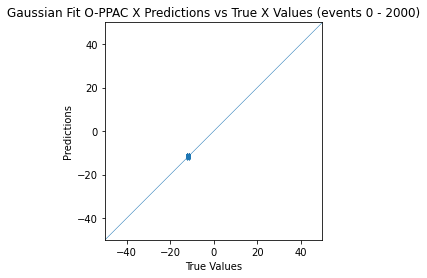

In [54]:
#graph showing the accuracy of gaussian fit by comparing predicted and true x values
#should be as close to the diagonal as possible
a = plt.axes(aspect='equal')

plt.scatter(x_labels, x_peaks_mm, s=6, marker = "x")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("Gaussian Fit O-PPAC X Predictions vs True X Values (events %0.0f - %0.0f)" %tuple(ranges))
plt.show()

In [52]:
#to find the locations of largest error within my predicted x values
#used for debugging
x_error = np.abs(x_peaks_mm - x_labels)

print(x_error.shape)

problem_indices_x = [idx for (idx, err) in enumerate(x_error) if err >= 10]
print(len(problem_indices_x))

(2000,)
0


In [49]:
#use to look at events which are causing error
#used for debugging
i = 21 #choose the index of problem_indices_x (above)
true_x = mm_to_diodenum(x_labels[problem_indices_x[i]])

plt.title('Problem Location Example (index = %5.0f)' %(problem_indices_x[i]+rangemin))
plt.plot(x2_data[problem_indices_x[i]], linewidth = 2, label = "x2 data")
plt.plot(x1_data[problem_indices_x[i]], linewidth = 2, color='orange', label = "x1 data")
plt.axvline(x = x_peaks[problem_indices_x[i]], color = "red", linestyle=":",label = "fit peak = %5.1f" %x_peaks[problem_indices_x[i]])
plt.axvline(x = x1_peaks[problem_indices_x[i]], color = "black", linewidth = 1, linestyle=":", label = "x1 fit peak = %5.1f" % x1_peaks[problem_indices_x[i]])
plt.axvline(x = x2_peaks[problem_indices_x[i]], color = "magenta", linewidth = 1, linestyle=":", label = "x2 fit peak = %5.1f" % x2_peaks[problem_indices_x[i]])
plt.axvline(x = true_x, color = "green", linestyle=":",label = "true peak = %5.1f" %true_x)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

IndexError: list index out of range

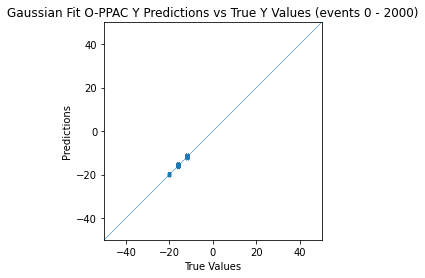

In [55]:
#graph showing the accuracy of gaussian fit by comparing predicted and true y values
#should be as close to the diagonal as possible
a = plt.axes(aspect='equal')

plt.scatter(y_labels, y_peaks_mm, s=6, marker = "x")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("Gaussian Fit O-PPAC Y Predictions vs True Y Values (events %0.0f - %0.0f)" %tuple(ranges))
plt.show()

In [56]:
#to find the locations of largest error within my predicted x values
#used for debugging
y_error = np.abs(y_peaks_mm - y_labels)

print(y_error.shape)

problem_indices_y = [idx for (idx, err) in enumerate(y_error) if err >= 10]
print(len(problem_indices_y))

(2000,)
0


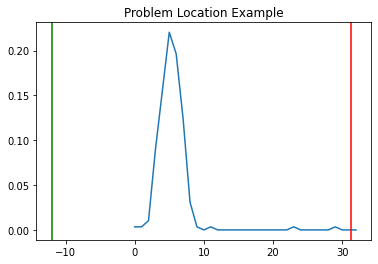

In [36]:
#graph locations of large y error (just like x error event grapher above)
#used for debugging
i = 0 #choose the index of the error (above)

plt.title('Problem Location Example')
plt.plot(y1_data_all[5125 + rangemin])
plt.axvline(x = y1_peaks[problem_indices_y[i]], color = "red")
plt.axvline(x = y_labels[problem_indices_y[i]], color = "green")
plt.show()

In [ ]:
#graphs the gaussian fit of the event of your choosing; check whether something is wrong with the fit or a bug
#used for debugging

In [57]:
#basic gaussian fit stuff; needs x and y inputs for all data points; index is both for the y data and for lower code
index = 13
x = np.arange(0,33,1)
y = x1_data[index,:]

print(y)
x_labels_index = range_size - (rangemax - index)

#the true location of the peak as given by the label for that event
x_peak_true_value = ((x_labels[x_labels_index]+48)/100)*33
x_peak_fit_value = x_peaks[x_labels_index]

[0.         0.         0.         0.         0.00357789 0.00357789
 0.         0.         0.00357789 0.03577892 0.11807043 0.21109563
 0.22540719 0.20393984 0.13595989 0.02862314 0.         0.
 0.00357789 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


In [58]:
#curve fit code; bounds might be able to be played with still to improve model (specifically sigma in index 1)
#trying new stuff to better balance k based on the input data
if np.max(y) > .20:
    kvalue = np.max(y)+(np.max(y)/2)
elif np.max(y) == 0:
    kvalue = 1
else:
    kvalue = np.max(y)

popt, _ = curve_fit(gaussianpdf, x, y, bounds=(0, [kvalue,10., 33.]))
print(popt[2])
print(x_peak_true_value)
print(x_peak_fit_value)

12.017972339263155
11.879999999999999
12.02005948444693


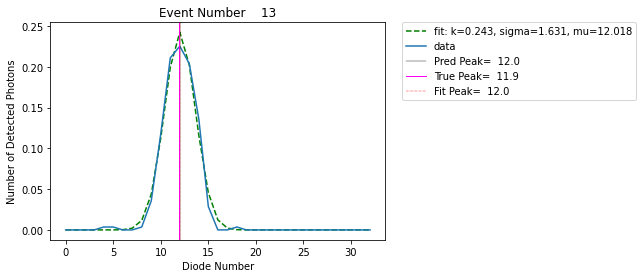

In [59]:
#plotting gaussian to make sure it looks logically correct
plt.plot(x, gaussianpdf(x, *popt), 'g--', label='fit: k=%5.3f, sigma=%5.3f, mu=%5.3f' % tuple(popt))
plt.plot(x1_data[index,:], label = "data")
plt.axvline(x = x_peak_fit_value, color = "black", linewidth=.4, label='Pred Peak= %5.1f' %x_peak_fit_value)
plt.axvline(x = x_peak_true_value, color = "magenta", linewidth=1, label='True Peak= %5.1f' % x_peak_true_value)
plt.axvline(x = popt[2], color = "red", linewidth=.4, linestyle='dashdot', label='Fit Peak= %5.1f' %popt[2])
plt.title('Event Number %5.0f' %index)
plt.xlabel('Diode Number')
plt.ylabel('Number of Detected Photons')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()